# Introduction to Tensorlab

by Paul Breiding (https://personal-homepages.mis.mpg.de/breiding/, breiding@mis.mpg.de).

This notebook is a tutorial for <font style="color:rgb(0,88,123)"> Tensorlab</font>, a MATLAB toolbox for tensor computations. You can download Tensorlab at
 
        https://www.tensorlab.net

Tensorlab requires MATLAB 7.9 (R2009b) or higher. To get MATLAB running in jupyter notebook follow the [guide](https://anneurai.net/2015/11/12/matlab-based-ipython-notebooks/) by [Anne Urai](https://anneurai.net). For convenience, I copied her guide here:

* Download and install [Anaconda](https://www.continuum.io/downloads). Restart Terminal. Or, if you’d prefer to not get the full Anaconda software, check out this post.
* In terminal, type
    "pip install pymatbridge"
    "pip install matlab_kernel" and 
    "python -m matlab_kernel install"
* Point the kernel to your version of Matlab. I added export

        "MATLAB_EXECUTABLE=/Applications/MATLAB_R2015b.app/bin/matlab" 
    
    to my .bash_profile file. To do this from Terminal, type echo 
    
        “export MATLAB_EXECUTABLE=/Applications/MATLAB_2015b.app/bin/matlab” >> ~/.bash_profile
    
    Of course, make sure the location and version of Matlab match yours. Restart terminal or load .bash_profile. Type ipython notebook in Terminal. 
* You’re now ready to run your notebook! 

As of August 2018 this did not work with Python 3.6, but it did work with Python 3.5. Here is a [guide](https://conda.io/docs/user-guide/tasks/manage-python.html#using-a-different-version-of-python) on how to switch between different Python version.

Tensorlab installation: unzip the files into a folder and add the folder to your current MATLAB session.

The pictures in this notebook are taken from the Tensorlab manual.

In [1]:
addpath('PATH_TO_THE_TENSORLAB_FOLDER')

Tensorlab provides functions for computing with tensors.

In this tutorial we will go through the functions for multilinear multiplication and consider algorithms for  computing three types of tensor decompositions:

* Multilinear singular value decomposition
* Block term decomposition
* Canonical polyadic decomposition (CPD)



### <font style="color:rgb(0,88,123)"> Multilinear Multiplication</font>


Recall that for $S\in \mathbb{R}^{n_1\times \cdots\times n_d}$ and $U_i\in\mathbb{R}^{m_i \times n_i}$ the multilinear multiplication is defined as follows: let $e_i$ denote the standard basis vectors and write $A=\sum s_{i_1,\ldots,i_d} \,e_{i_1}\otimes \cdots\otimes e_{i_d}$. Then

$$ (U_1,\cdots,U_d)\,s := \sum a_{i_1,\ldots,i_d} s_{i_1,\ldots,i_d}\,(M_1e_{i_1})\otimes \cdots\otimes (M_de_{i_d}).$$





In [2]:
% generate a random tensor
S = rand(2,2,2) 

% generate random matrices
U1 = rand(4,2); U2 = rand(4,2); U3 = rand(2,2);

% multilinear multiplication (U1, U2, U3) S
S0 = tmprod(S, {U1, U2, U3}, 1:3) 


% print the sizes of the two tensors
['S has format ' num2str(size(S)) ' and S0=(U1,U2,U3)S has format ' num2str(size(S0))]


S(:,:,1) =

    0.8147    0.1270
    0.9058    0.9134


S(:,:,2) =

    0.6324    0.2785
    0.0975    0.5469


S0(:,:,1) =

    1.5188    1.5444    2.3696    2.7507
    1.0691    1.2372    1.7094    1.9966
    0.8689    0.6823    1.3001    1.4927
    0.7419    1.0138    1.2290    1.4479


S0(:,:,2) =

    1.3400    1.4319    2.1098    2.4548
    0.9191    1.1095    1.4821    1.7348
    0.7991    0.6830    1.2110    1.3952
    0.6127    0.8750    1.0254    1.2110


ans =

    'S has format 2  2  2 and S0=(U1,U2,U3)S has format 4  4  2'





### <font style="color:rgb(0,88,123)">Multilinear Singular Value Decomposition (MLSVD)</font>

![img](lmlra.svg)
    
<b><font style="color:rgb(152,17,53)">Reminder:</font></b> the singular value decomposition (SVD) of a matrix $T\in\mathbb{R}^{n\times m}$ ($n\leq m$): $T = U \,\Sigma \,V^T, \text{ where } \Sigma = \mathrm{diag}(\sigma_1,\ldots,\sigma_m)$ and where $U\in \mathbb{R}^{n\times m}, V\in\mathbb{R}^{m\times m}$ have orthonormal columns and $\sigma_1\geq \cdots\geq \sigma_m\geq 0$ are the singular values. 



* The rank of $T$ is the number of non-zero singular values.

* The best rank-$r$ approximation $S$ to $T$ is $S = U \,\mathrm{diag}(\sigma_1,\ldots,\sigma_r,0,\ldots,0) \,V^T = WW^TT,$ where $W\in \mathbb{R}^{n\times r}$ is the matrix consisting of the first $r$ columns of $U$.


The idea behind MLSVD is to compute the SVDs of the <b><font style="color:rgb(152,17,53)">flattenings</font></b> of a tensor:
 
$$\text{For } 1\leq i\leq d: \; T\in\mathbb{R}^{n_1 \times \cdots \times n_d} \;\stackrel{\text{reshape}}{\longrightarrow}\; T_{(i)}\in\mathbb{R}^{n_i \times (\prod_{j\neq i} n_j)}.$$ 

In [3]:
% Consider, for instance, the following 3x2x2 tensor T
% T will act as a running example throughout this presentation

T(:,:,1) = [0.2582 0.2622;0.4087 0.5949; 0.5959 0.2622];
T(:,:,2) = [0.5261 0.5244;0.8174 1.1898;1.1898 0.5244]


T(:,:,1) =

    0.2582    0.2622
    0.4087    0.5949
    0.5959    0.2622


T(:,:,2) =

    0.5261    0.5244
    0.8174    1.1898
    1.1898    0.5244



Let us compute the matricization $T_{(1)}$ and its SVD.

In [4]:
% the following two scripts do the same thing:

% script 1
T1 = tens2mat(T, 1); %compute the flattening in the first mode
[U Sigma] = svd(T1); %compute the SVD of T1
T_first = tmprod(T, {U'}, [1]) %compress T 

% script 2
[Us, S, sv] = mlsvd(T); % Compute the MLSVD 
U = Us{1}; % extract the first U
T_second = tmprod(T, {U'}, [1]) % compress T

% compare outputs
['The frobenius distance between the two transformed tensors is ' num2str(frob(T_first - T_second))]


T_first(:,:,1) =

   -0.7464   -0.6728
    0.1781   -0.1969
    0.0037    0.0000


T_first(:,:,2) =

   -1.4951   -1.3456
    0.3540   -0.3937
   -0.0019    0.0000


T_second(:,:,1) =

   -0.7464   -0.6728
    0.1781   -0.1969
    0.0037    0.0000


T_second(:,:,2) =

   -1.4951   -1.3456
    0.3540   -0.3937
   -0.0019    0.0000


ans =

    'The frobenius distance between the two transformed tensors is 7.228e-16'



### <font style="color:rgb(0,88,123)">Definition </font>
Let $T\in \mathbb{R}^{n_1\times \cdots\times n_d}$. The multilinear rank $(r_1,\ldots,r_d)$ of $T$ is defined by $r_i:=\mathrm{rank}(T_{(i)})$.

<br>

What is the ml-rank of $T$? Let us plot the singular values of the three matricizations.

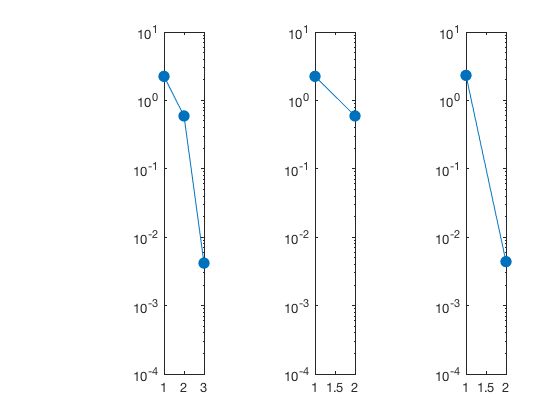

In [5]:
for n = 1:3
    subplot(1,6,2*n); semilogy(sv{n}, '.-', 'MarkerSize', 25); ylim([1e-4 10]);
end

It seems that $T$ is almost of ml-rank $(2,2,1)$. This motivates the following definition.


### <font style="color:rgb(0,88,123)">Definition</font>
<p>
    
Let $T\in \mathbb{R}^{n_1\times \cdots\times n_d}$ and let the SVD of the $i$-th flattening be $ T_{(i)} = U_i \Sigma_i, V_i^T.$

The rank-$(r_1,\ldots,r_d)$ low multilinear rank approximation (LMLRA) of $T$ is the tuple 

$$(W_1,\ldots,W_d, S)\in \mathbb{R}^{n_1\times r_1}\times \cdots\times \mathbb{R}^{n_d\times r_d} \times \mathbb{R}^{r_1\times \cdots\times r_d}, \text{ where }$$

* $W_i$ is the matrix consisting of the first $r_i$ columns of $U_i$.
* $S = (W_1^T,\ldots,W_d^T) \,T$
<p>
    
(so that $W_iW_i^TT_{(i)}$ is the best rank $r_i$-approximation of $T_{(i)}$).

<br>

Benefit of an $(r_1,\ldots,r_d)$ LMLRA: storing $\prod_{i=1}^d r_i + \sum_{i=1}^d n_ir_i$ numbers vs. storing  $\prod_{i=1}^d n_i$ many numbers. The next theorem shows the quality of LMLRA.

### <font style="color:rgb(0,88,123)">Theorem (Hackbusch)</font>
<p>
    
Let $(W_1,\ldots,W_d, S)$ be the the rank-$(r_1,\ldots,r_d)$ LMLRA of $T\in \mathbb{R}^{n_1\times \cdots\times n_d}$. Then,

$$\Vert T-(W_1,\ldots,W_d)\,S\Vert \leq \sqrt{d}\,\min\limits_{C\in \mathbb{R}^{n_1\times \cdots\times n_d} \text{ has ml-rank } (r_1,\ldots,r_d)} \Vert A-C\Vert.$$



<br>


Let us compute the rank-$(2,2,1)$ LMLRA of $T$ and see how well $T$ was approximated.

In [6]:
% compute the (2,2,1)-MLSVD approximation
[U, S, sv] = mlsvd(T, [2, 2, 1]); 

%generate the tensor from the tuple (U_1,U_2,U_3,S)
B = lmlragen(U,S) ;

%compute the relative error of the approximation
['The relative error of the LMLRA of T is ' num2str(frob(T-B) / frob(T))]


ans =

    'The relative error of the LMLRA of T is 0.0018884'



### <font style="color:rgb(0,88,123)">Block Term Decomposition (BTD)</font>


![img](btd.svg)

    
    
### <font style="color:rgb(0,88,123)">Definition</font>
<p>





Let  $T\in \mathbb{R}^{n_1\times \cdots\times n_d}$  and $r = ((r_1^1,\ldots,r_d^1), \ldots, (r_1^R,\ldots,r_d^R))$ be a $R$-tuple of $d$-tuples of positive integers. We call the decomposition $T = T_1 + \cdots + T_R$ a $r$-block term decomposition (BTD) of $A$, if $\text{ml-rank}(T_i)=(r_1^i,\ldots,r_d^i)$. The smallest such $R$ is called the BTD-rank of $T$.

<b><font style="color:rgb(152,17,53)">Goal of BTD:</font></b> find the best $r$-block term approximation; i.e. compute

$$ \min_{B \text{ has an } r-\text{BTD}}\Vert T-B\Vert.$$

Unlike for the LMLRA we have no direct method for solving this approximation problem. Tensorlab provides an optimization algorithm for solving this problem. In a nutshell, this algorithm solves the gradient equation of $\,f(B)=\frac{1}{2}\Vert T-B\Vert^2$ using a Riemann-Newton method. This method requires an initial decomposition (and hence requires specification of the rank $R$). 

See also [Absil, Mahony, Sepulchre (2008): Optimization Algorithms on Matrix Manifolds.](http://www.eeci-institute.eu/GSC2011/Photos-EECI/EECI-GSC-2011-M5/book_AMS.pdf)

In [7]:
% define size of the tensor T
size_tens = [3 2 2]; 

% define ml-ranks of the decomposition
r = {[2 2 2],[2 2 2],[2 2 1]}; 

% generate a random BTD, which can serve as initial point
U = btd_rnd(size_tens, r);

% compute a block term approximation of T with initial decomposition U
T0 = btd_nls(T, U); 

% Compare the decomposition with T
['The relative error of the BTD approximation of T is ' num2str(frob(T - btdgen(T0)) / frob(T))]


ans =

    'The relative error of the BTD approximation of T is 4.8128e-13'




### <font style="color:rgb(0,88,123)">Canonical Polyadic Decomposition (CPD)</font>

![img](cpd.svg)
    
The CPD expresses a tensor $T\in\mathbb{R}^{n_1\times \cdots \times n_d}$ as a sum of rank-one tensors: $T = \sum_{i=1}^R a_1^i\otimes \cdots \otimes a_d^i.$ The smallest $R$, for which such a decomposition is possible, is called the rank of $T$.  Tensorlab's data structure for dealing with CPDs are <b><font style="color:rgb(152,17,53)">cells of factor matrices</font></b>.

### <font style="color:rgb(0,88,123)">Definition</font>

The factor matrices of the decomposition $T = \sum_{i=1}^R\, a_1^i\otimes \cdots \otimes a_d^i$ are $A_1:=  [a_1^1, \ldots, a_1^R] \in \mathbb{R}^{n_1\times R}, \,\ldots,\, A_d:=  [a_d^1, \ldots, a_d^R]\in \mathbb{R}^{n_d\times R}.$

<br>

Let us make an example




In [8]:
% define a rank
R = 2; 

% sample random factor matrices with R columns
A = rand(2, R); 
B = rand(3, R); 
C = rand(2, R); 

% create the rank-2 2x3x2 tensor with factor matrices A,B,C
cpdgen({A, B, C}) 


ans(:,:,1) =

    0.1735    0.1989    0.0254
    0.2597    0.2218    0.0083


ans(:,:,2) =

    0.0813    0.0939    0.0122
    0.1036    0.0890    0.0036



Tensorlab's high-level command for computing CPDs is cpd($\;\cdot\;$):

In [9]:
% compute a rank-3 cpd of T
R = 3;
U = cpd(T, R) 

% compute the relative error
['The relative error of the CPD approximation of T is ' num2str(frob(T - cpdgen(U)) / frob(T))]


U =

  1×3 cell array

    [3×3 double]    [2×3 double]    [2×3 double]


ans =

    'The relative error of the CPD approximation of T is 1.6015e-16'



Algorithms for computing the CPD in Tensorlab are

* cpd_gevd (a direct method for tensors of order 3)
* cpd_als and cpd_nls (optimization algorithm).

In [10]:
% compute the CPD of T via GEVD. The size of T only allows GEVD for ranks at most 2.
U = cpd_gevd(T, 2) 

% compute the relative error
['Using GEVF the relative error of the CPD approximation of T is ' num2str(frob(T - cpdgen(U)) / frob(T))] 


U =

  1×3 cell array

    [3×2 double]    [2×2 double]    [2×2 double]


ans =

    'Using GEVF the relative error of the CPD approximation of T is 0.0017996'



cpd_gevd computes the CPD via a generalized eigenvalue decomposition. But this method is numerically unstable and therefore should be used carefully; see https://arxiv.org/abs/1807.04159.

The optimization algorithms solve the optimization problem

$$\min_{\text{factor matrices } A_1,\ldots, A_d} \; \frac{1}{2} \,\Vert T -  \sum_{i=1}^R\, a_1^i\otimes \cdots \otimes a_d^i\Vert^2.$$

* cpd_als sequentially optimizes over the $A_i$.
* cpd_nls applies Newton's method to solve the gradient equation. 

Let us decompose $T$ with cpd_als and cpd_nls.

In [11]:
R = 3;

% use cpd_nls 
U_nls = cpd(T, R, 'Algorithm', @cpd_nls); 

% use cpd_als
U_als = cpd(T, R, 'Algorithm', @cpd_als);

%  compute the relative errors
['Using cpd_nls the relative error is ' num2str(frob(T - cpdgen(U_nls)) / frob(T))] 

['Using cpd_als the relative error is ' num2str(frob(T - cpdgen(U_als)) / frob(T))] 


ans =

    'Using cpd_nls the relative error is 1.6367e-16'


ans =

    'Using cpd_als the relative error is 0.00040781'



Alternatively, one can call cpd_nls and cpd_als directly, but one has to pass an intial decomposition. The rank is implicitly defined by the number of columns of the factor matrices.

In [12]:
R = 3;

% sample a random decomposition U
U0 = {rand(3,R), rand(2,R), rand(2,R)}; 

% compute the CPD of T with starting guess U
U = cpd_nls(T, U0); 

% compute the relative error
['Using cpd_nls the relative error is ' num2str(frob(T - cpdgen(U)) / frob(T))]


ans =

    'Using cpd_nls the relative error is 1.6882e-16'



In https://arxiv.org/abs/1709.00033 it was argued that it can be benificial to solve instead the following problem

$$\min_{T_i \,\text{ has rank one}} \; \frac{1}{2} \,\Vert T -  \sum_{i=1}^R\, T_i\Vert.$$

In particular, for large differences in the $\Vert T_i\Vert$ solving this optimization problem instead of using factor matrices improves the numerical stability as the following experiment shows.

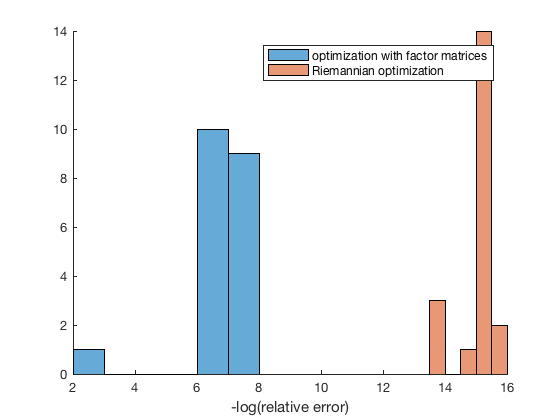

In [13]:
% !!!
% for the code in this box to work download the ancillary files at https://arxiv.org/abs/1709.00033 
% and add the MATLAB scripts to your session 
% !!!

% define a rank and an array to store the accuracies of the computations
R = 6; 
accuracy = zeros(20, 2);

% define scaling 5^i factors for T_i 
scaling = arrayfun(@(i) 2^i, 1:R); 

for i = 1:20

    % generate a random tensor with the above scaling
    Y = cpdgen({rand(13,R) * diag(scaling), rand(11,R), rand(9,R)});

    % generate a random intial decomposition
    U0 = {rand(13,R), rand(11,R), rand(9,R)};

    % compute the CPD with optimization on the factor matrices
    U_factor_matrices = cpd_nls(Y, U0); 

    % compute the CPD with optimization on the rank-one tensors
    U_segre = bv_rgn_hr(Y, U0); 

    % save the errors of the computations
    accuracy(i,1) = -log10(frob(Y - cpdgen(U_factor_matrices)) / frob(Y));
    accuracy(i,2) = -log10(frob(Y - cpdgen(U_segre)) / frob(Y));
    
end

hold on; 
histogram(accuracy(:,1)); 
histogram(accuracy(:,2)); 
legend('optimization with factor matrices','Riemannian optimization'); 
xlabel('-log(relative error)')


### <font style="color:rgb(0,88,123)">Structured Data Fusion</font>


Tensorlab allows to impose structures on the factors in the optimization algorithms. Structure is imposed on factors by transforming variables $z$ into factors $x$ and optimizing over $z$. 

In Tensorlab 3.0 there are 41 structures implemented, such as

* nonnegativity,
* orthogonality,
* Hankel or
* Toeplitz.

The user can also write their own structure function. 

Furthermore, with SDF the user can solve coupled problems.


### <b><font style="color:rgb(0,88,123)">Example</font></b>

Let us consider the [GeoLife GPS Trajectories data set](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=http%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) from Microsoft Research (also available as Tensorlab demo).

The dataset contains the tensor UserLocAct, which has as entries the counts of 164 users in 168 locations doing 5 activities. A CPD of this tensor can be interpreted as the decomposition of the join probability distribution of the random variable (User, Location, Activity) into a mixture of independence models.




In [14]:
% load the dataset
load('aaai10.uclaf.data.mat'); 

% compute a rank-2 CPD of the data
U = cpd(UserLocAct, 2); 

% compute the relative error
['The relative error of the approximation is ' num2str(frob(UserLocAct - cpdgen(U)) / frob(UserLocAct))]


ans =

    'The relative error of the approximation is 0.4927'



<b><font style="color:rgb(152,17,53)">Problem:</font></b> The factors in the CPD can only be interpreted as independence models, if their entries are <b><font style="color:rgb(152,17,53)">nonnegative</font></b>. Let us impose the structure "nonnegative" on the factors in the CPD. In Tensorlab this is done as follows: first one initializes a struct with the data.

In [15]:
% initialize the model
model = struct; 

% add the data to the model "nonnegative"
model.factorizations.nonnegative.data = UserLocAct; 

Then, the variables are the defined. We start with a rank $R=2$ decomposition. The factors are defined as positive variables.

In [16]:
R = 2;
model.variables.u   = rand(164,R);  % variable u 
model.variables.l   = rand(168,R);  % variable l
model.variables.a   = rand(5,R);    % variable a

model.factors.U   = {'u', @struct_nonneg};  % declare nonnegative factor U dependend on variable u
model.factors.L   = {'l', @struct_nonneg};  % declare nonnegative factor L dependend on variable l
model.factors.A   = {'a', @struct_nonneg};  % declare nonnegative factor A dependend on variable a

Now, we can compute a CPD of the model.

In [17]:
% add a CPD to the model.
model.factorizations.nonnegative.cpd  = {'U','L','A'}; 

% solve the model
sol = sdf_nls(model)

% extract the factors
f = sol.factors
U = {f.U, f.L, f.A};

% compute the relative error
['The relative error of the approximation is ' num2str(frob(UserLocAct - cpdgen(U)) / frob(UserLocAct))]


sol = 

  struct with fields:

    variables: [1×1 struct]
      factors: [1×1 struct]
         info: [1×1 struct]


f = 

  struct with fields:

    U: [164×2 double]
    L: [168×2 double]
    A: [5×2 double]


ans =

    'The relative error of the approximation is 0.4927'



Consider now the following problem: we wish to decompose UserLocAct as before, but in addition we would like to compute the coupled interactions between users and users, and locations and users. With SDF it is possible to solve coupled models.

In [18]:
%
% as above we first define variables and factors
%

model = struct;

% define variables 
R = 2; 
model.variables.u   = rand(164,R);   
model.variables.l   = rand(168,R);   
model.variables.a   = rand(5,R);
model.variables.duu   = rand(1,R);  
model.variables.dul   = rand(1,R);

% define factors 
model.factors.U   = {'u', @struct_nonneg};   
model.factors.L   = {'l', @struct_nonneg};   
model.factors.A   = {'a', @struct_nonneg};
model.factors.DUU   = {'duu', @struct_nonneg}; 
model.factors.DUL   = {'dul', @struct_nonneg};

%
% Instead of one factorization, we simply write three factorizations into the model. 
%

% factorization 1
model.factorizations.fac1.data = UserLocAct; 
model.factorizations.fac1.cpd  = {'U','L','A'}; 

% factorization 2
model.factorizations.fac2.data = UserUser;  
model.factorizations.fac2.cpd  = {'U','U','DUU'}; 

% factorization 3
model.factorizations.fac3.data = UserLoc; 
model.factorizations.fac3.cpd  = {'U','L','DUL'};

We can now solve the model with sdf_solve.

In [19]:
% solve the model
sol = sdf_nls(model); 

% extract the computed factors
f = sol.factors; 

% error of the 1st factorization
U1 = {f.U, f.L, f.A};
['The relative error in the first factorization is ' num2str(frob(UserLocAct - cpdgen(U1)) / frob(UserLocAct))]


% error of the 2nd factorization
U2 = {f.U, f.U, f.DUU};
['The relative error in the second factorization is ' num2str(frob(UserUser - cpdgen(U2)) / frob(UserUser))]

% error of the 3rd factorization
U3 = {f.U, f.L, f.DUL};
['The relative error in the third factorization is ' num2str(frob(UserLoc - cpdgen(U3)) / frob(UserLoc))] 


ans =

    'The relative error in the first factorization is 0.56892'


ans =

    'The relative error in the second factorization is 0.999'


ans =

    'The relative error in the third factorization is 0.55084'



For more examples, see the Tensorlab Demos at 

         https://www.tensorlab.net/demos/ 

(including a long version of the last example). The Tensorlab online manual is available at https://www.tensorlab.net/doc/.